In [1]:
import pandas as pd

from tabular.pipeline import *
from tabular.experiment import *
from researcher.records import *

import matplotlib.pyplot as plt

In [2]:
# trn = pd.read_csv("data/train.csv")

In [3]:
# subset = trn.sample(3000).reset_index()

In [4]:
def agg_proc(group_cols, agg_col, aggs, agg_names=None, fill_missing=False):
    if agg_names:
        if len(agg_names) != len(aggs):
            raise ValueError("If custom names are provided, one name is required for each aggregation function. Received aggregations {}, names {}".format(aggs, agg_names))
    
    def aggregated(df, trn_idx, targets):       
        if agg_col in targets:
            stats_df = df.iloc[trn_idx]
            if not fill_missing:
                for col in group_cols:
                    if stats_df[col].nunique() < df[col].nunique():
                        raise ValueError("{} values, {} for column {} exist in the training dataframe but not the validation dataframe. Ensure that the training dataframe covers all groups".format(df[col].nunique() - stats_df[col].nunique(), set(df[col].unique()) - set(stats_df[col].unique()), col))
                        
        else:
            stats_df = df

        grouped = stats_df[group_cols + [agg_col]].groupby(group_cols)
        
        for i, agg in enumerate(aggs):
            agg_name = agg_col + "_" + agg
            agg = grouped.agg(agg)

            if agg_names:
                new_name = agg_names[i]
            else:
                new_name = "-".join(group_cols) + "_wise_" + agg_name
                
            agg = agg.rename({agg_col: new_name}, axis=1)
            
            df = pd.merge(df, agg, how="left", on=group_cols, suffixes=("", ""))
            
            if fill_missing:
                df = df.fillna(df[new_name].mean())
            
        return df, None
    
    return aggregated

In [5]:
PIPELINES["bid_mean_enc_reduce"] = Pipeline(
[
    reduce_proc(["building_id", "meter", "meter_reading"]),
    agg_proc(["building_id"], "meter_reading", ["mean"], fill_missing=True),
    agg_proc(["building_id", "meter"], "meter_reading", ["mean", "median"], fill_missing=True), 
], ["meter_reading"])




PIPELINES["log_drop"] = Pipeline([
    lambda df, idx, target: (df[df["meter_reading"] < 30000].reset_index(), None),
    target_log1n_proc,
],
["meter_reading"])

In [6]:
params = {
    "title": "test",
    "notes": " some human readable sentence",
    "model": "linear_reg",
    "path": "data/train.csv",
    "folds": 5,
    "pipeline": "log_drop",
    "fold_pipeline": "bid_mean_enc_reduce",
    "metrics": ["mse"],                                                       
    "x_cols": ["building_id_wise_meter_reading_mean", "building_id-meter_wise_meter_reading_mean", "building_id-meter_wise_meter_reading_median", "meter"],
    "y_cols": ["meter_reading"],
}

In [7]:
res = run_experiment(params, "records/")

running experiment ed6a4acbbc4ac3275f93406eadaa42b9

--------- Starting fold 0 ---------
--------- Starting fold 1 ---------
--------- Starting fold 2 ---------
--------- Starting fold 3 ---------
--------- Starting fold 4 ---------


In [8]:
res.get_fold_aggregated_metric("mse", np.mean)

array([717206.97358805])

In [9]:
res.get_metric("mse")

[[961878.0149828178],
 [384020.6545385493],
 [805673.0906446022],
 [657259.2199077584],
 [777203.8878665181]]

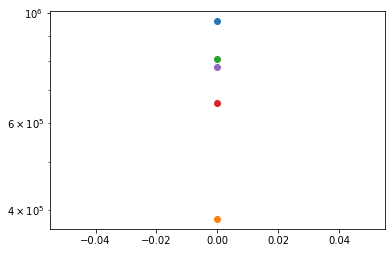

In [10]:
res = past_experiment_from_hash("records/", "43dcb5a96c86f411e65beba37a01e649").results
fig, ax = plt.subplots()
ax.set_yscale("log")


for fold in res.get_metric("mse"):
    ax.scatter(0, np.array(fold))

In [11]:
np.log(0.0000001)

-16.11809565095832

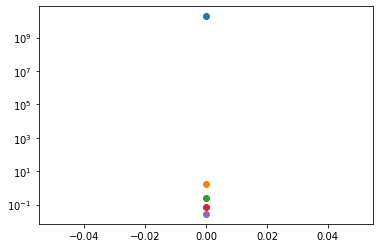

In [12]:
res = past_experiment_from_hash("records/", "6cdaf144eaab115080b6cb5404e3cbbe").results
fig, ax = plt.subplots()
ax.set_yscale("log")


for fold in res.get_metric("mse"):
    ax.scatter(0, np.array(fold))